In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_compression as tfc
import matplotlib.pyplot as plt

import os
import h5py

from BalleFFP import BalleFFP
from read_data import read_data_numpy

2023-03-06 08:37:14.508202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 08:37:14.653656: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-06 08:37:15.185367: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ubuntu/data/miniconda3/envs/tf2/lib/
2023-03-06 08:37:15.185479: W tensorflow/co

## General Settings

In [27]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [2]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"]   = 14

In [3]:
tf.config.set_visible_devices([], 'GPU')

2023-03-06 08:37:17.371354: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 08:37:17.372561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 08:37:17.382026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 08:37:17.383100: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 08:37:17.384044: I tensorflow/compiler/xla/stream_executo

## Functions

In [4]:
def get_model_files(folder, name):
    files  = os.listdir(folder)
    files  = [f for f in files if name in f]
    models = [f for f in files if "model" in f]
    losses = [f for f in files if "losses" in f]
    return models, losses

In [33]:
def show_image_comparison(fig, reco_1, reco_2, format_1, format_2):
    """Visualize the original image and the reconstructed image side by side."""
    if format_1=='channels_first':
        reco_1 = np.transpose(reco_1, (1, 2, 0))
    if format_2=='channels_first':
        reco_2 = np.transpose(reco_2, (1, 2, 0))
    
    # check if the images are normalized
    norm_reco_1 = np.max(reco_1)  <= 1.0
    norm_reco_2 = np.max(reco_2) <= 1.0

    # Create a 4x4 grid of images
    axes = fig.subplots(1, 2)
    
    axes[0].imshow(reco_1  if norm_reco_1 else reco_1.astype(np.uint8)) 
    axes[1].imshow(reco_2  if norm_reco_2 else reco_2.astype(np.uint8)) 
    
    axes[0].axis('off')
    axes[1].axis('off')
    
    return axes

In [22]:
def select_random_images(data, n, id=None):
    """Selects n random images from the data. The id parameters forces the selection of specific images."""
    
    # if id is None then select n random images
    if id is None:
        idx = np.random.choice(data.shape[0], n, replace=False)
    else:
        idx = id
    return data[idx], idx

## Constants

In [8]:
DATA_FOLDER  = "../data/stl10/stl10_binary/"
DATA_FILE    = "unlabeled_X.bin"

CH_FORMAT_1 = "channels_first"
EPOCHS_1    = 50
NORM_1      = "normFalse"

CH_FORMAT_2 = "channels_last"
EPOCHS_2    = 50
NORM_2      = "normFalse"

MODEL_FOLDER = "../models/"

## Load Data

In [9]:
data_path = os.path.join(DATA_FOLDER, DATA_FILE)
data_1      = read_data_numpy(data_path, CH_FORMAT_1).astype('float32') 
data_2      = read_data_numpy(data_path, CH_FORMAT_2).astype('float32') 

if NORM_1 == "normTrue":
    # normalize the data to [0,1]
    data_1 = data_1 / 255.0
    
if NORM_2 == "normTrue":
    # normalize the data to [0,1]
    data_2 = data_2 / 255.0

## Choose the trained model

In [10]:
name_1 = "ffp_{}_epochs{}_{}".format(CH_FORMAT_1, EPOCHS_1, NORM_1)
name_2 = "ffp_{}_epochs{}_{}".format(CH_FORMAT_2, EPOCHS_2, NORM_2)

models_1, losses_1 = get_model_files(MODEL_FOLDER, name_1)
models_2, losses_2 = get_model_files(MODEL_FOLDER, name_2)

print("Found {} models and {} losses for {}.".format(len(models_1), len(losses_1), name_1))
print("Found {} models and {} losses for {}.".format(len(models_2), len(losses_2), name_2))


model_path_1 = os.path.join(MODEL_FOLDER, models_1[-1])
loss_path_1  = os.path.join(MODEL_FOLDER, losses_1[-1])

model_path_2 = os.path.join(MODEL_FOLDER, models_2[-1])
loss_path_2  = os.path.join(MODEL_FOLDER, losses_2[-1])

Found 1 models and 1 losses for ffp_channels_first_epochs50_normFalse.
Found 1 models and 1 losses for ffp_channels_last_epochs50_normFalse.


## Train/Test loss

In [13]:
# open the .h5 file containing the losses and load them as two numpy arrays train_loss and test_loss
with h5py.File(loss_path_1, 'r') as f_1: # type: ignore
    train_loss_1 = np.array(f_1['train'])
    test_loss_1  = np.array(f_1['test'])
    
with h5py.File(loss_path_2, 'r') as f_2: # type: ignore
    train_loss_2 = np.array(f_2['train'])
    test_loss_2  = np.array(f_2['test'])

In [15]:
def plot_loss(fig, epochs, train_loss, test_loss, ax=None, id=111, label="", color="tab:blue"):
    """Plot the loss curves for the training and validation data."""
    
    if ax is None:
        ax = fig.add_subplot(id)
    
    ax.plot(epochs, train_loss, lw=2, ls="-",  color=color, label=label)
    ax.plot(epochs, test_loss,  lw=2, ls="--", color=color)

    return ax

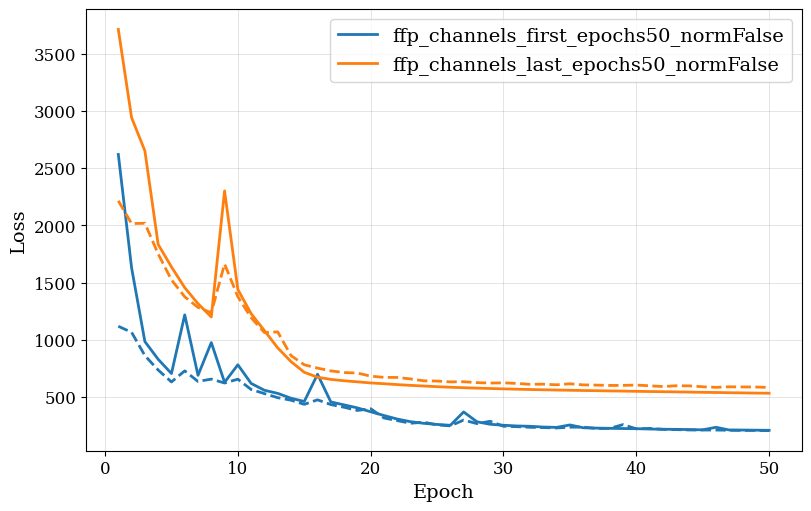

In [20]:
epochs_1= np.arange(1, len(train_loss_1)+1)
epochs_2= np.arange(1, len(train_loss_2)+1)


fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
ax.grid(True, which='both', ls='-', lw=0.5, c='grey', alpha=0.3)

ax = plot_loss(fig, epochs_1, train_loss_1, test_loss_1, ax=ax, id=111, label=name_1, color="tab:blue")
ax = plot_loss(fig, epochs_2, train_loss_2, test_loss_2, ax=ax, id=111, label=name_2, color="tab:orange")

ax.legend()

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.tick_params(axis='both', which='major', labelsize=12)

# fig.savefig("./plots/ffp_loss_comparison.png", dpi=300, facecolor="w")

plt.show()

## Image Reconstruction

In [21]:
vae_1 = BalleFFP(N=128, M=192, k2=3, c=3, format=CH_FORMAT_1)

if CH_FORMAT_1 == 'channels_first':
    x = tf.zeros((1, 3, 96, 96))
    
elif CH_FORMAT_1 == 'channels_last':
    x = tf.zeros((1, 96, 96, 3))
else:
    raise ValueError("CH_FORMAT must be either 'channels_first' or 'channels_last'")

# call the model to create the weights
_ = vae_1(x)

# load the weights from the .h5 file
vae_1.load_weights(model_path_1)


vae_2 = BalleFFP(N=128, M=192, k2=3, c=3, format=CH_FORMAT_2)

if CH_FORMAT_2 == 'channels_first':
    x = tf.zeros((1, 3, 96, 96))
    
elif CH_FORMAT_2 == 'channels_last':
    x = tf.zeros((1, 96, 96, 3))
else:
    raise ValueError("CH_FORMAT must be either 'channels_first' or 'channels_last'")

# call the model to create the weights
_ = vae_2(x)

# load the weights from the .h5 file
vae_2.load_weights(model_path_2)

2023-03-06 08:51:33.096701: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [51]:
img_1, ids_1 = select_random_images(data_1, 4)
img_2, ids_2 = select_random_images(data_2, 4, ids_1)

img_reco_1, rate_reco_1 = vae_1(img_1) # type: ignore
img_reco_2, rate_reco_2 = vae_2(img_2) # type: ignore

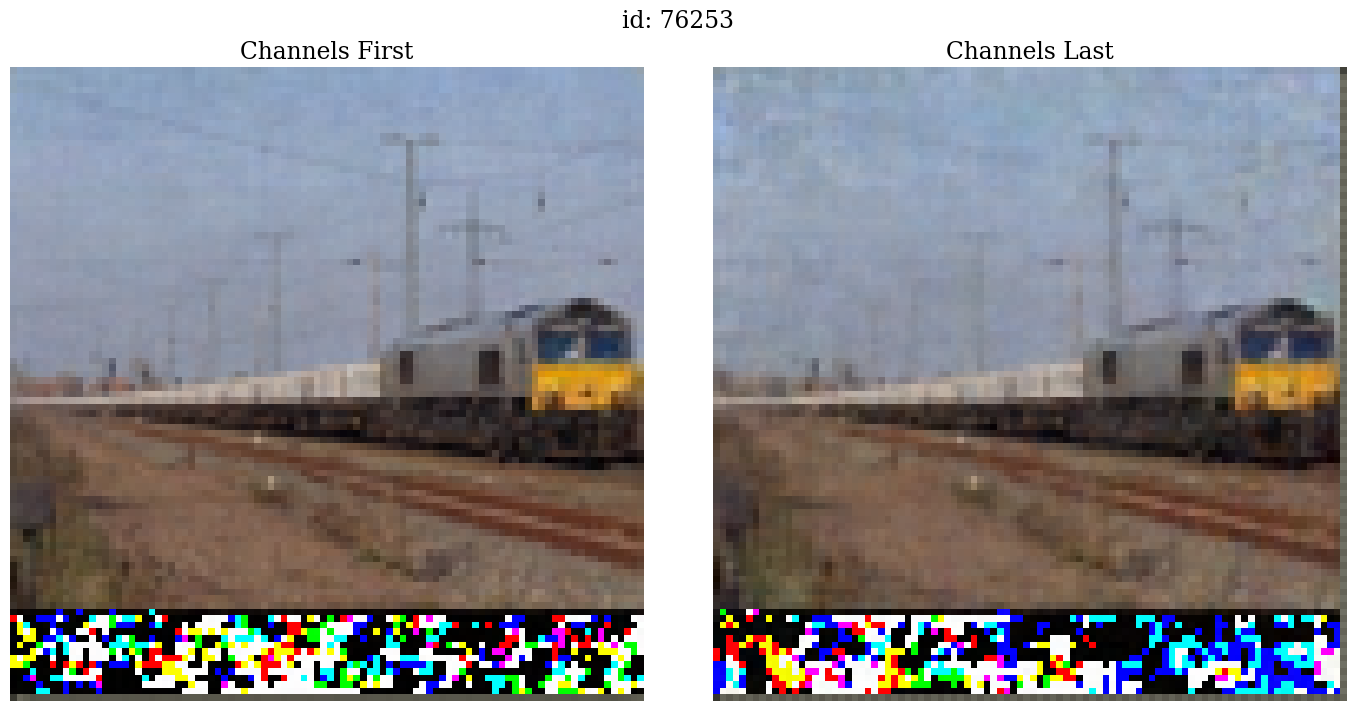

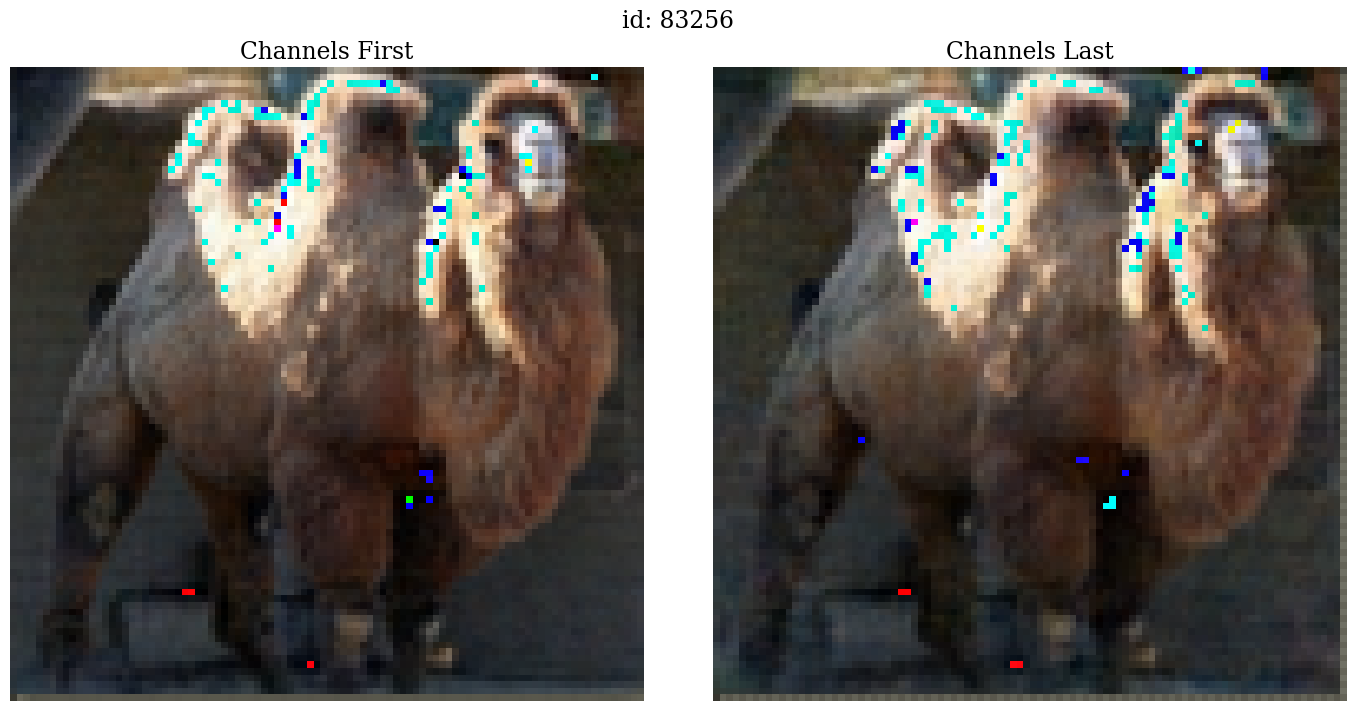

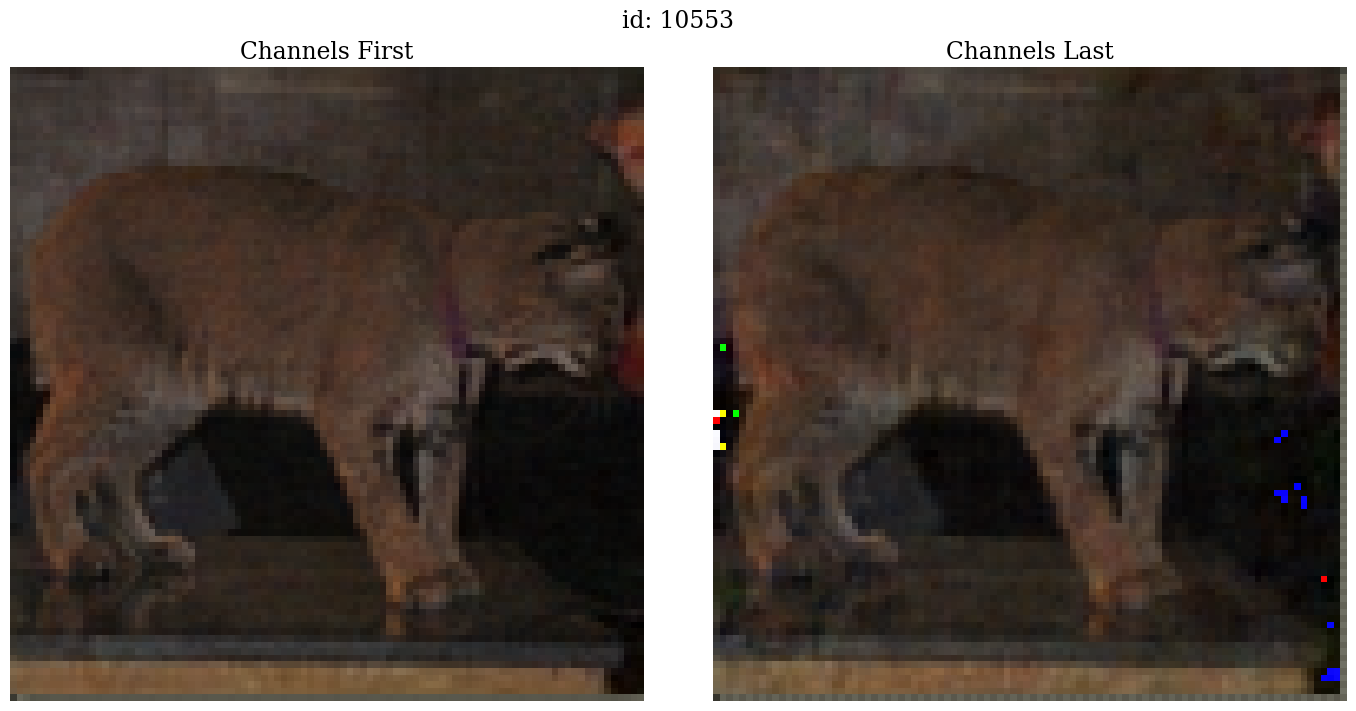

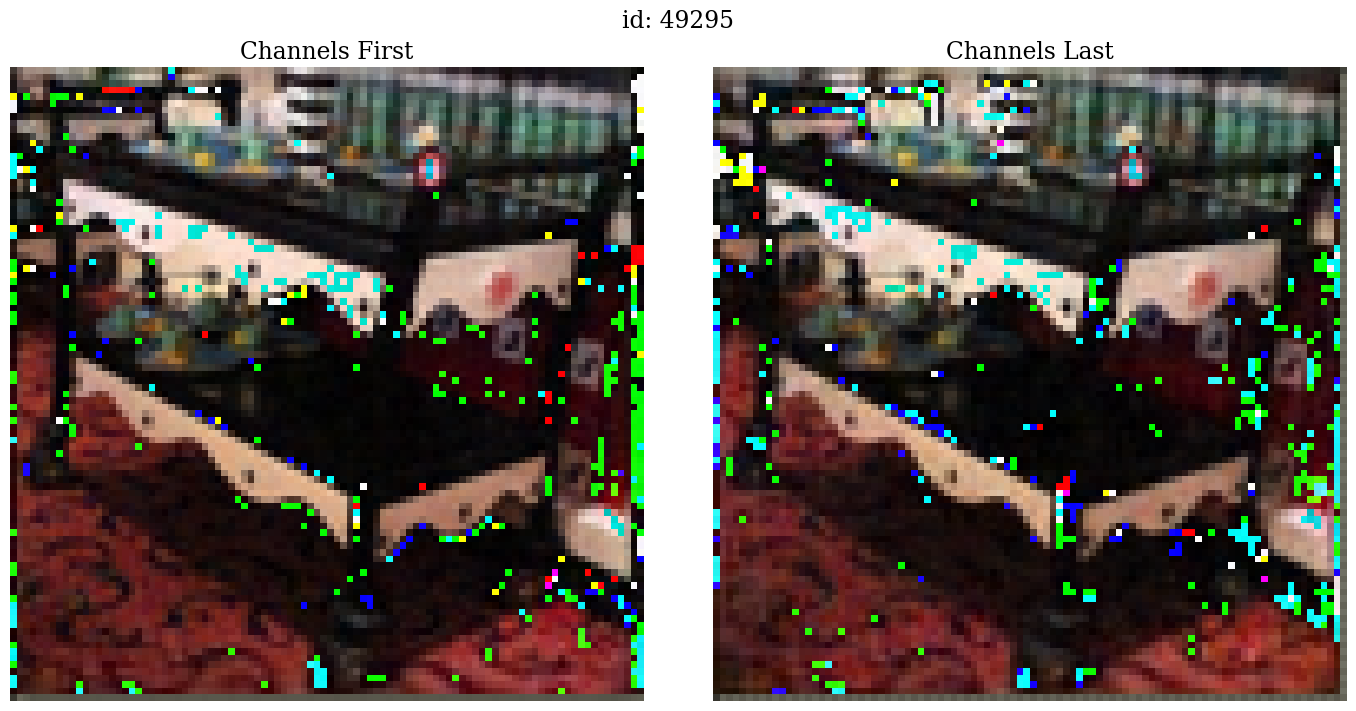

In [53]:
for i in range(img_1.shape[0]):
    
    fig = plt.figure(figsize=(14, 7), constrained_layout=True)
    
    fig.suptitle('id: {}'.format(ids_1[i]))
    
    axes = show_image_comparison(fig, img_reco_1[i], img_reco_2[i], CH_FORMAT_1, CH_FORMAT_2)
    
    axes[0].set_title("Channels First")
    axes[1].set_title("Channels Last")
    
    # fig.savefig("./plots/ffp_reco_comparison_{}.png".format(ids_1[i]), dpi=300, facecolor="w")
    
    plt.show()